## Dropout nad Batch Normalization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np

In [2]:
device = torch.device("cuda:0")

learning_rate = 0.001
epochs = 15
batch_size = 128
drop_prob = 0.3

- dataset 로드할 때 transform.ToTensor() 
    - Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

In [3]:
# MNIST dataset
mnist_train = datasets.FashionMNIST(root='fMNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.FashionMNIST(root='fMNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [5]:
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.dense1 = nn.Linear(784,512)
        self.dense2 = nn.Linear(512,256)
        self.dense3 = nn.Linear(256,256)
        self.dense4 = nn.Linear(256,10)
        self.relu = F.relu
        self.dropout = nn.Dropout(p=drop_prob)
    
    def forward(self, x):
        output = self.dropout(self.relu(self.dense1(x)))
        output = self.dropout(self.relu(self.dense2(output)))
        output = self.dropout(self.relu(self.dense3(output)))
        output = self.dense4(output)
        return output

In [6]:
model = DropoutModel().to(device)

In [7]:
nn.init.xavier_uniform_(model.dense1.weight)
nn.init.xavier_uniform_(model.dense2.weight)
nn.init.xavier_uniform_(model.dense3.weight)
nn.init.xavier_uniform_(model.dense4.weight)

Parameter containing:
tensor([[-0.0827, -0.1171,  0.1469,  ..., -0.0796,  0.0164,  0.1064],
        [ 0.1003,  0.0673, -0.0182,  ..., -0.0278,  0.0728,  0.0082],
        [-0.1091,  0.1088, -0.0876,  ..., -0.0554,  0.1121, -0.1344],
        ...,
        [ 0.0339, -0.1448, -0.0862,  ..., -0.1397,  0.0028,  0.0900],
        [-0.0252,  0.0420,  0.0388,  ..., -0.0847, -0.1357, -0.0034],
        [ 0.0999,  0.0589, -0.1237,  ..., -0.1225,  0.1414, -0.1031]],
       device='cuda:0', requires_grad=True)

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

- Dropout, Batch norm 적용 시 주의 사항
    - model.train()을 선언 후 train
    - model.eval() 선언 후 inference
    - automatically set drop rate =0 at test time

- model.eval()
    - Sets the module in evaluation mode.
    - This has any effect only on certain modules. See documentations of particular modules for details of their behaviors in training/evaluation mode, if they are affected, e.g. Dropout, BatchNorm, etc.

In [9]:
total_batch = len(data_loader)  #60,000/128 = 468
model.train()
for epoch in range(epochs):    
    avg_loss = 0
    for X_batch, Y_batch in data_loader:
        X_batch = torch.reshape(X_batch, [-1, 784]).to(device)
        Y_batch = Y_batch.to(device)
        
        pred = model(X_batch)
        loss = criterion(pred, Y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
    avg_loss /= total_batch
    print('epoch:', epoch, 'loss: ', avg_loss.item())

epoch: 0 loss:  0.6045709252357483
epoch: 1 loss:  0.43082085251808167
epoch: 2 loss:  0.39101991057395935
epoch: 3 loss:  0.3691750764846802
epoch: 4 loss:  0.3505077660083771
epoch: 5 loss:  0.3376268148422241
epoch: 6 loss:  0.3283565938472748
epoch: 7 loss:  0.31764182448387146
epoch: 8 loss:  0.3111459016799927
epoch: 9 loss:  0.30625754594802856
epoch: 10 loss:  0.2989547848701477
epoch: 11 loss:  0.29528555274009705
epoch: 12 loss:  0.28643736243247986
epoch: 13 loss:  0.2826641798019409
epoch: 14 loss:  0.2770489454269409


In [10]:
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=128, shuffle=False)

In [11]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in test_loader:
        images, labels = data
        output = model(images.view(-1,784).to(device))
        _, predicted = torch.max(output, dim=1)        
        total += labels.size(0)
        correct += (predicted ==labels.to(device)).sum().item()

print('Accuracy on test images with dropout:', (correct / total))

Accuracy on test images with dropout: 0.885


### Batch normalization

<img src=attachment:image.png width=400><center>*source: https://arxiv.org/pdf/1502.03167.pdf</center>
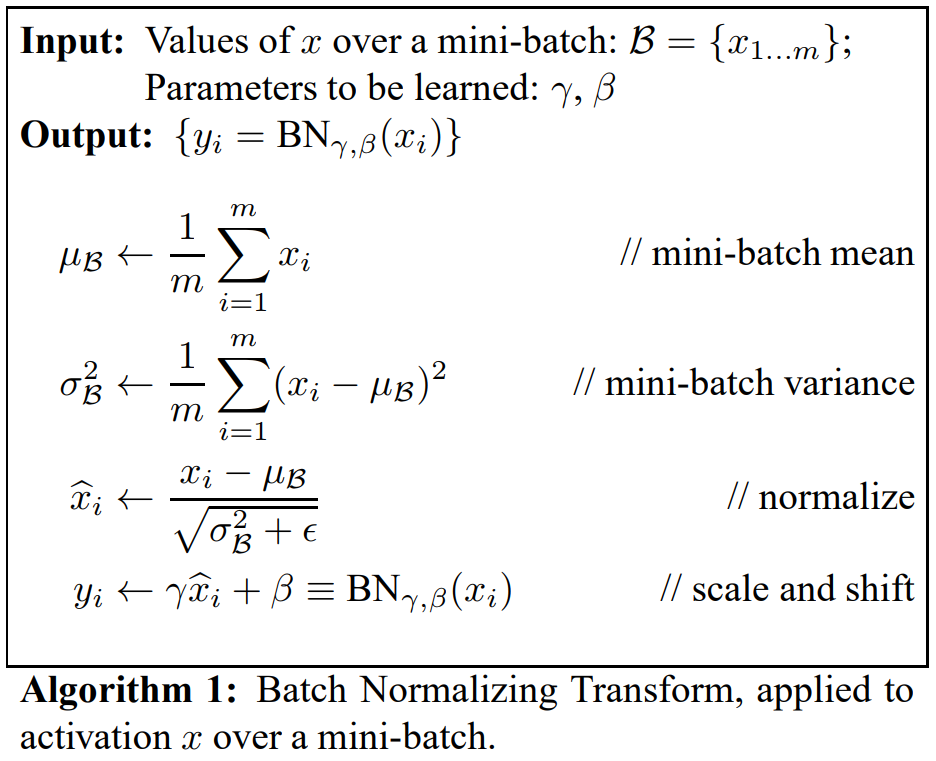

In [12]:
class BatchnormModel(nn.Module):
    def __init__(self):
        super(BatchnormModel, self).__init__()
        self.dense1 = nn.Linear(784,512)
        self.dense2 = nn.Linear(512,256)
        self.dense3 = nn.Linear(256,256)
        self.dense4 = nn.Linear(256,10)
        self.relu = F.relu
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(256)
            
    def forward(self, x):
        output = self.relu(self.bn1(self.dense1(x)))
        output = self.relu(self.bn2(self.dense2(output)))        
        output = self.relu(self.bn3(self.dense3(output)))
        output = self.dense4(output)
        return output

In [13]:
model = BatchnormModel().to(device)

In [14]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
total_batch = len(data_loader)  #60,000/128 = 468
model.train()
for epoch in range(epochs):    
    avg_loss = 0
    for X_batch, Y_batch in data_loader:
        X_batch = torch.reshape(X_batch, [-1, 784]).to(device)
        Y_batch = Y_batch.to(device)
        
        pred = model(X_batch)
        loss = criterion(pred, Y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
    avg_loss /= total_batch
    print('epoch:', epoch, 'loss: ', avg_loss.item())

epoch: 0 loss:  0.4629743993282318
epoch: 1 loss:  0.330311119556427
epoch: 2 loss:  0.2900663912296295
epoch: 3 loss:  0.2661219537258148
epoch: 4 loss:  0.24240458011627197
epoch: 5 loss:  0.22644712030887604
epoch: 6 loss:  0.21152335405349731
epoch: 7 loss:  0.19788777828216553
epoch: 8 loss:  0.18054252862930298
epoch: 9 loss:  0.17072805762290955
epoch: 10 loss:  0.15931223332881927
epoch: 11 loss:  0.14792115986347198
epoch: 12 loss:  0.1384425163269043
epoch: 13 loss:  0.12909062206745148
epoch: 14 loss:  0.1196528822183609


In [16]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in test_loader:
        images, labels = data
        output = model(images.view(-1,784).to(device))
        _, predicted = torch.max(output, dim=1)        
        total += labels.size(0)
        correct += (predicted ==labels.to(device)).sum().item()

print('Accuracy on test images with bn:', (correct / total))

Accuracy on test images with bn: 0.8832
